### Process the real (raw) Merian data
1. Scale the image to `ZP = 27.0` (same as HSC).
2. Subtract background. **TODO: Have to consider the effect of background subtraction and image scaling on the weight map.**
3. Extract PSF at a given position
    
    Download and install `psfex`: https://github.com/esheldon/psfex

    Documentation: https://psfex.readthedocs.io/en/latest/GettingStarted.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack, vstack
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

import pickle
from IPython.display import clear_output


Bad key savefig.frameon in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc

In [3]:
import sep
from kuaizi.utils import save_to_fits
import os
import sys

In [30]:
yifei_cat = Table.read('/scratch/gpfs/jiaxuanl/Data/Merian/Catalogs/COSMOS_tractor_gaap.fits')
song_cat = Table.read('/tigress/MERIAN/poststamps/g09_broadcut/g09_broadcut_cosmos-2022-03-21.fits')
# Match the two
yifei_ids = [int(name.replace('cosmos_', '').replace('_y', '')) for name in yifei_cat['name']]
song_ids = song_cat['name']

cutout_cat = song_cat[np.in1d(song_ids, yifei_ids)]
cutout_cat.rename_column('name', 'ID')
cutout_cat.rename_column('prefix', 'PREFIX')
yifei_cat.rename_column("ID", 'ID_yifei')
yifei_cat.remove_column('DEC')

cutout_cat = hstack([cutout_cat, yifei_cat])
cutout_cat.write('/scratch/gpfs/jiaxuanl/Data/Merian/Catalogs/COSMOS_cutouts_tractor_gaap.fits', overwrite=True)

In [31]:
cutout_cat[:200].write(
    '/scratch/gpfs/jiaxuanl/Data/Merian/Catalogs/COSMOS_cutouts_tractor_gaap_test.fits', overwrite=True)

In [16]:
iN708_gaap = (cutout_cat['i_gaap_mag'] - cutout_cat['N708_gaap_mag']).data
iN708_tractor = 2.5 * (np.log10(cutout_cat['N708_tractor_flux']) - np.log10(cutout_cat['i_tractor_flux']))

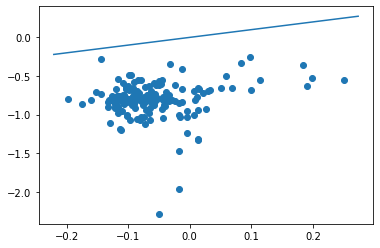

In [27]:
plt.scatter(iN708_gaap[:200], iN708_tractor[:200])
x = plt.gca().get_xlim()
x = np.linspace(*x, 100)
plt.plot(x, x)

In [17]:
np.where(np.abs(iN708_gaap - iN708_tractor) > 0.5)

(array([    0,     1,     2, ..., 10706, 10707, 10708]),)

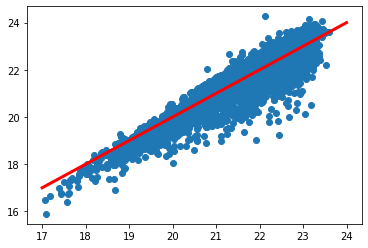

In [80]:
plt.scatter(cutout_cat['i_gaap_mag'], -2.5 * np.log10(cutout_cat['i_tractor_flux']) + 22.5)

x = np.linspace(17, 24)
plt.plot(x, x, lw=3, color='r')

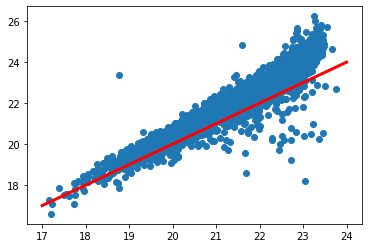

In [73]:
plt.scatter(cutout_cat['N708_gaap_mag'], -2.5 * np.log10(cutout_cat['N708_tractor_flux']) + 22.5)

x = np.linspace(17, 24)
plt.plot(x, x, lw=3, color='r')

---

In [5]:
kuaizi.set_env(project='Merian', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/Merian/'

In [6]:
obj_cat = Table.read('./Catalogs/COSMOS_cutouts_tractor_gaap.fits')

### Also need to generate HSC cutouts

In [7]:
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts')
from s18a_batch_cutout import batch_cutout

In [8]:
DATADIR="/scratch/gpfs/jiaxuanl/Data/" # Directory of all data
LSBGDIR="/scratch/gpfs/jiaxuanl/Data/Merian/"

In [14]:
for obj in obj_cat[:200]:
    file = os.path.join(obj['dir'], f'{obj["PREFIX"]}_n540_deepCoadd.fits')
    newfile = file.replace('/projects/MERIAN/poststamps/g09_broadcut', 
                           '/scratch/gpfs/jiaxuanl/Data/Merian/Cutout')
    newfile = newfile.replace('n540', 'N540')
    os.system(f'cp {file} {newfile}')
    
    file = os.path.join(obj['dir'], f'{obj["PREFIX"]}_n540_psf.fits')
    newfile = file.replace('/projects/MERIAN/poststamps/g09_broadcut', 
                           '/scratch/gpfs/jiaxuanl/Data/Merian/Cutout')
    newfile = newfile.replace('n540', 'N540')
    os.system(f'cp {file} {newfile}')

In [101]:
# print('ZP=', merian_hdu[0].header['MAGZERO'])
# skysub = merian_hdu[0].header['SKYSUB']
# print('SKYSUB=', skysub)
# img -= skysub

In [102]:
# img *= 10**((27.0 - merian_hdu[0].header['MAGZERO']) / 2.5) # scale to ZP = 27.0

In [13]:
# bkg = sep.Background(img, bw=256, bh=256)
# bkg.globalback
# display_single(bkg.back());

In [14]:
# You can save background and bkg-subtracted image, if you like
# save_to_fits(bkg.back(), '../merian_images/merian_cosmos_bkg256.fits')
# save_to_fits(img - bkg.back(), '../merian_images/merian_cosmos_N708_bkgsub.fits', wcs=w_img)